In [1]:
%load_ext tensorboard.notebook

In [2]:
!rm -rf ./logs/ 

In [3]:
import tensorflow as tf
import datetime

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

In [5]:
from IPython import display

In [7]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [8]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [9]:
train_labels = tf.one_hot(train_labels,10)

In [10]:
train_labels[0]

<tf.Tensor: id=8, shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)>

In [11]:
BATCH_SIZE = 256

In [12]:
img_input = layers.Input(shape=(28,28,1))

In [14]:
def generator_model(input_layer, condition_layer):
    
    merged_in = layers.Concatenate()([input_layer, condition_layer])
    
    hid = layers.Dense(7*7*256, use_bias=False)(merged_in)
    hid = layers.BatchNormalization()(hid)
    hid = layers.LeakyReLU()(hid)

    hid = layers.Reshape((7, 7, 256))(hid)

    hid = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(hid)
    hid = layers.BatchNormalization()(hid)
    hid = layers.LeakyReLU()(hid)

    hid = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(hid)
    hid = layers.BatchNormalization()(hid)
    hid = layers.LeakyReLU()(hid)

    out = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(hid)

    model = tf.keras.Model(inputs=[input_layer, condition_layer], outputs=out)
    model.summary()
    
    return model

In [15]:
def discriminator_model(input_layer, condition_layer):

    
    hid = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(input_layer)
                                    
    hid = layers.LeakyReLU()(hid)
    hid = layers.Dropout(0.4)(hid)

    hid = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(hid)
    hid = layers.LeakyReLU()(hid)
    hid = layers.Dropout(0.4)(hid)

    hid = layers.Flatten()(hid)
    
    merged = layers.Concatenate()([hid, condition_layer])
    hid = layers.Dense(128, activation="sigmoid")(merged)
    out = layers.Dense(1)(hid)
    
    model = tf.keras.Model(inputs=[input_layer, condition_layer], outputs=out)
    model.summary()
    
    return model

In [16]:
disc_cond_in = layers.Input(shape=(10,)) # Nombre de classes
gen_cond_in = layers.Input(shape=(10,))

In [17]:
discriminator = discriminator_model(img_input, disc_cond_in)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   1664        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 14, 14, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 14, 14, 64)   0           leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [18]:
noise_input = layers.Input(shape=(100,))
generator = generator_model(noise_input, gen_cond_in)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 110)          0           input_4[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 12544)        1379840     concatenate_1[0][0]        

In [19]:
noise = tf.random.normal([1,100])
condition = tf.one_hot([7],10)

In [20]:
generated = generator([noise,condition],training=False)

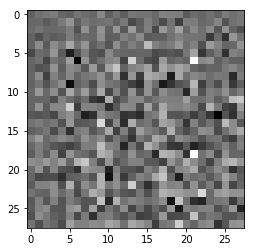

In [21]:
plt.imshow(generated[0, :, :, 0], cmap='gray')

In [22]:
decision = discriminator([generated,condition], training=False)
print (decision)


tf.Tensor([[-0.54818976]], shape=(1, 1), dtype=float32)


In [23]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
def discriminator_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    #La real_loss va quantifier notre loss pour distinguer les vraies images
    
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    #La fake_loss va quantifier notre loss pour distinguer les fausses images (générées)
    
    #Vrai = 1, faux =0 (array de 1 et zéros, de taille 1 dans notre cas)
    total_loss = real_loss + fake_loss
    return total_loss

In [25]:
def generator_loss(fake_output):
    #On veut que notre fausse image soit considérée vraie (1)
    return loss_function(tf.ones_like(fake_output), fake_output)


In [26]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [7]:
checkpoint_dir = './training_checkpoints_conditionnal'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

NameError: name 'generator_optimizer' is not defined

In [35]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16 #Pour l'affichage

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_labels = tf.one_hot([0,1,2,3,4,5,6,7,8,9,1,2,3,8,7,9], 10)

In [31]:


# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise,labels] , training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



In [32]:
def train(train_images, train_labels, epochs):
    num_batches = int(train_images.shape[0]/BATCH_SIZE)
    for epoch in range(epochs):
        start = time.time()

        for batch_idx in range(num_batches):
            images = train_images[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
            labels = train_labels[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
            train_step(images, labels)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed,
                                 seed_labels)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               seed,
                                seed_labels)


In [33]:
def generate_and_save_images(model, epoch, test_input, conditions):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model([test_input, conditions], training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [36]:
%%time
train(train_images, train_labels, EPOCHS)

TypeError: generate_and_save_images() missing 1 required positional argument: 'conditions'

In [37]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [38]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

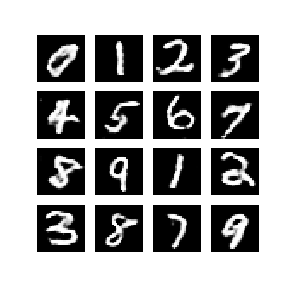

In [39]:
display_image(EPOCHS)

In [40]:
anim_file = 'conditionnal_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./imgs_c/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 10*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

